In [2]:
import numpy as np
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt

In [252]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = datasets.load_wine()
X_train, X_test, y_train, y_test = train_test_split(data["data"], data["target"])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).T
X_test = scaler.transform(X_test).T
y_train = (y_train == 0).astype(np.int64)
y_test = (y_test == 0).astype(np.int64)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13, 133) (13, 45) (133,) (45,)


In [293]:
class activation_func:

    def __init__(self, raw_func, derivative):
        self.raw_func = raw_func
        self.derivative = derivative
    
    def apply(self, X):
        return self.raw_func(X)

    def gradient(self, X):
        return self.derivative(X)

In [467]:
# new grad func
def calcLoss(actual, pred):
    return - actual / pred + (1 - actual) / (actual - pred)

# sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# gets error for log reg
def calcGrad(actual, pred):
    return pred - actual

def roundCalcGrad(actual, pred):
    return np.round(pred - actual, 0)

# l2 regularisation
def l2Reg(layers):
    return np.sqrt(np.sum(np.power(np.concatenate([l.w.flatten() for l in layers]), 2)))

# try building a general network
class NetLayer:

    def __init__(self, input_dim, output_dim, activation_func, keep_prob = 1):
        # note weight dimensions are reversed from typical nnet specs
        self.w = np.random.randn(input_dim, output_dim)
        self.b = np.random.randn(output_dim, 1)
        self.activation_func = activation_func
        # value for dropout - default 1 for no dropout
        self.keep_prob = keep_prob

    def forward(self, X, train = True):
        # record activations
        self.A_L_minus_one = X.copy()
        if train:
            dropout_mat = np.random.rand(X.shape[0], X.shape[1]) < self.keep_prob
            A = np.multiply(dropout_mat, X) / self.keep_prob
        else:
            A = X
        self.A_L = self.activation_func(np.dot(self.w.T, A) + self.b)
        # pass activation to next layer
        return self.A_L.copy()

    def backward(self, da, m, lambd):
        dz = da * self.A_L * (1 - self.A_L)
        da = np.dot(self.w, dz)
        dw = 1/m * (np.dot(dz, self.A_L_minus_one.T) + lambd * self.w.T)
        db = np.sum(dz, axis = 1, keepdims= True) / m
        return da, dw, db

    def update_weights(self, new_weights, new_bias):

        self.w += new_weights
        self.b += new_bias

class NeuralNetwork:
    
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X, train = True):
        for L in self.layers:
            X = L.forward(X, train = train)
        return X

    def train(self, X, y, error_func = lambda x, y: y - x, reg_func = lambda x: 0, epochs = 1, learning_rate = 0.01, batch_size = 150, lambd = 0):

        """
        Specify training set (X), training targets (y)

        Rest of arguments are defaults
        """

        # initialise weights
        for l in self.layers:
            l.w *= 2 / batch_size
            l.b *= 2 / batch_size


        # record training errors
        errors = {i:0 for i in range(epochs)}

        for i in range(epochs):

            samps = np.arange(0, X.shape[1], 1)
# print(k)
            np.random.shuffle(samps)
# print(k)
            batches = [k[(i * batch_size):((i+1) * batch_size)] for i in range(round(X.shape[1] / batch_size))]
            # get a random batch sample
            # if batch_size < X.shape[1]:
            #     samps = [np.random.randint(X.shape[1]) for i in range(batch_size)]
            #     y_actual = y[samps]
            #     A = X[:,samps].copy()
            # else:
            #     A = X.copy()
            #     y_actual = y
            for batch in batches:
                A = X[:, samps].copy()
                y_actual = y[samps]
                # forward pass
                A = self.forward(A)

                # calc the error - reg if lambd > 0
                da = error_func(y_actual, A) + lambd / (2 * batch_size) * reg_func(self.layers)

                errors[i] += np.sum(np.abs(da))

                # back prop
                for j in range(len(self.layers) - 1, -1, -1):
                    current_layer = self.layers[j]
                    da, dw, db = current_layer.backward(da, batch_size, lambd)
                    ### convert dimensions back using transpose because of our convention - (input_dim, output_dim)
                    update_w = - learning_rate * dw.T 
                    update_b = - learning_rate * db
                    current_layer.update_weights(update_w, update_b)
        return errors

    def predict(self, X):
        # forward pass
        A = self.forward(X, train = False)
        return A



<AxesSubplot:>

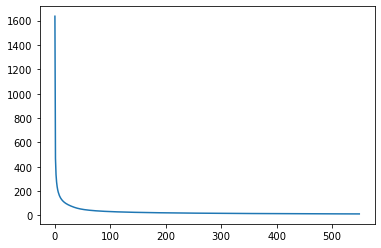

In [474]:
layer1 = NetLayer(13, 7, sigmoid)
layer2 = NetLayer(7, 1, sigmoid)
layer3 = NetLayer(3, 1, sigmoid)

layers = [
    layer1,
    layer2,
    # layer3
]

net = NeuralNetwork(layers)


results = net.train(X_train, y_train, batch_size = 1, epochs =550, learning_rate=0.1, lambd = 0, reg_func=l2Reg)

# check that cost function is converging
pd.Series(results).plot()

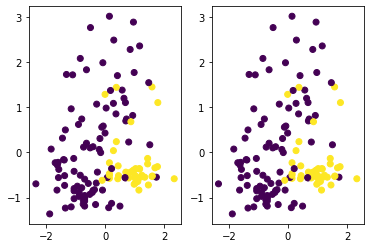

In [475]:
preds = np.round(net.predict(X_train))
fig, ax = plt.subplots(1,2)

# check how well our predictions match the truth
# note just training set - just checking that our model does work as we expect, not generalisability
ax[0].scatter(X_train[0,:], X_train[1,:], c = y_train)
ax[1].scatter(X_train[0,:], X_train[1,:], c = preds);

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        92
           1       0.98      1.00      0.99        41

    accuracy                           0.99       133
   macro avg       0.99      0.99      0.99       133
weighted avg       0.99      0.99      0.99       133



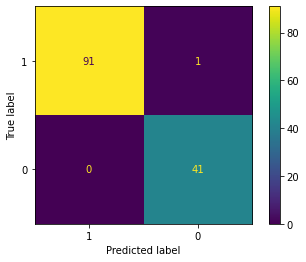

In [472]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_train, preds.reshape(X_train.shape[1]))
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()
print(classification_report(y_train, preds.reshape(X_train.shape[1])))

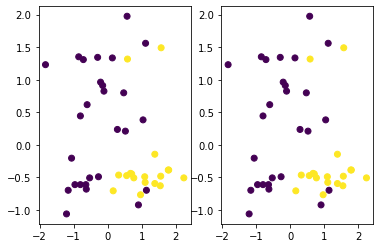

In [473]:
preds = np.round(net.predict(X_test))
fig, ax = plt.subplots(1,2)

# check how well our predictions match the truth
# note just training set - just checking that our model does work as we expect, not generalisability
ax[0].scatter(X_test[0,:], X_test[1,:], c = y_test)
ax[1].scatter(X_test[0,:], X_test[1,:], c = preds);

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        18

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



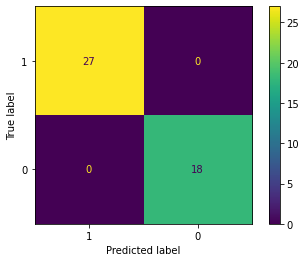

In [408]:
cm = confusion_matrix(y_test, preds.reshape(45))
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()
print(classification_report(y_test, preds.reshape(45)))

In [261]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state = 1, max_iter = 99999,fit_intercept = True, penalty = 'none')
log_reg.fit(X_train.T, y_train)
print(log_reg.coef_, log_reg.intercept_)


[[ 10.77485564   3.41257165   9.13173472 -11.45379633   1.7811926
    0.94929371   5.07852655  -1.87961345  -1.58192996  -1.43922209
   -2.06985119   9.83827421   9.85803728]] [-12.27431112]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        18

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



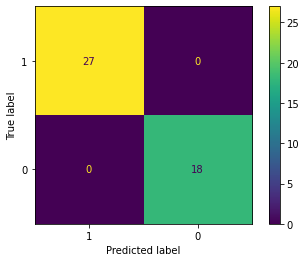

In [262]:

log_preds = log_reg.predict(X_test.T)

cm = confusion_matrix(y_test, log_preds)
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()
print(classification_report(y_test, log_preds))

In [459]:
batch_size = X_train.shape[1]

print(X_train.shape[1] / batch_size)
k = np.arange(0, X_train.shape[1], 1)
# print(k)
np.random.shuffle(k)
# print(k)
batches = [k[(i * batch_size):((i+1) * batch_size)] for i in range(round(X_train.shape[1] / batch_size))]

print(batches)
# if batch_size < X.shape[1]:
#     samps = [np.random.randint(X.shape[1]) for i in range(batch_size)]
#     y_actual = y[samps]
#     A = X[:,samps].copy()

1.0
[array([ 42, 119,  53,  35, 126,  78,  39,  51,   1,  82, 122, 109,  64,
        46, 107,  43,  72,  24,  15,  56, 123,  61,  81,  67,  87, 130,
       105,  91, 121,  94,  44, 118,  34,  86,  13,   9,  25,  92,  58,
        50,  74,  26,   5, 112,  47,   2,  89,  16,   0,  27,  63,  75,
        10, 102,  68,  62,  97,  76,  84,  38,  60,  41,  69,  18,  37,
        31,  98,  93, 124,  48,  55, 131,   4, 132,  49,  79, 101,  77,
        40, 117, 127, 128,  45,  23,   8,  83, 108, 106, 115,  36, 120,
        21,  59,  12, 111,  95,   6,  85,  14,  20,  11,  65, 103,  28,
         7,  17,  96, 114,  99,  80, 125,  29,   3,  32, 100,  90, 129,
        57,  30, 104,  66,  22,  52,  54,  70, 110, 116,  19,  73,  88,
        71,  33, 113])]


In [ ]:
k[(0 * batch_size):(i * batch_size)]